In [1]:
from Environment import GridworldEnv
import numpy as np
from collections import defaultdict 
import matplotlib.pyplot as plt
import pickle as pk


In [2]:
class RandomAgent:
    def __init__(self, env: GridworldEnv):
        self.env = env
        """
        possible actions:
        UP = 0
        RIGHT = 1
        DOWN = 2
        LEFT = 3
        """
        self.possible_actions = np.arange(self.env.nA)  # [0,1,2,3]
        self.possible_action = self.env.action_space.n  # 4
        self.method = "QL"
        self.Q_table = defaultdict(lambda: defaultdict(int))
        try:
            with open("Q_table_SARSA.pk", 'rb') as handle:
                self.Q_table["SARSA"] = pk.load(handle)
            with open("Q_table_QL.pk", 'rb') as handle:
                self.Q_table["QL"] = pk.load(handle)                
            print("Found Saved File, Loading Q Table")
        except:
            print("Did not find saved file. Creating New Q Table")

    def get_max_reward_action(self, state, method):
        '''
        Input the state and return the best move at that state
        '''
        values = np.array([self.Q_table[method][state, action] for action in range(self.possible_action)])
        action = np.argmax(values)
        return action

    def train(self, method = "QL", num_games = 10001, alpha = 0.1,
                             gamma = 0.9, epsilon = 1.0, temporary_game_check = 20000, plot_result = True):

        # screening & initializing
        if method not in {"QL", "SARSA"}:
            raise ValueError("No such method! Try again!")
        print(f"Training of {method} Method!")
        self.method = method
        successful_steps = []
        game_rewards = [] 
        for i in range(num_games):
            # printing to check process
            if i % temporary_game_check == 0:
                print('starting game', i)

            # foreach game, reset the environment            
            # cart x position, cart velocity, pole theta, pole velocity
            s = self.env.reset()
            # e-greedy policy: epsilon chance of exploring and (1-epsilon) chance of exploiting 
            rand = np.random.random()
            a = self.get_max_reward_action(s, method) if rand < (1 - epsilon) else self.env.action_space.sample()
            done = False

            number_of_steps = 0
            game_reward = 0

            # keep playing
            while not done:
                '''
                Move to the next state, use the next state value to update back the current state
                '''
                
                # Move to next state
                state, reward, done, info = self.env.step(a)
                game_reward += reward
                # update (depends on learning method)
                if method == "QL":
                    # off policy
                    self.Q_table[method][s,a] = self.Q_table[method][s,a] + alpha*(reward + gamma*self.Q_table[method][state, self.get_max_reward_action(state, method)] - self.Q_table[method][s,a])

                    rand = np.random.random()
                    a_ = self.get_max_reward_action(state, method) if rand < (1-epsilon) else self.env.action_space.sample()
                
                elif method == "SARSA":
                    rand = np.random.random()
                    a_ = self.get_max_reward_action(state, method) if rand < (1-epsilon) else self.env.action_space.sample()

                    # on policy
                    self.Q_table[method][s,a] = self.Q_table[method][s,a] + alpha*(reward + gamma*self.Q_table[method][state, a_] - self.Q_table[method][s,a])

                # update next state
                s, a = state, a_        

                number_of_steps += 1

            # epsilon decay every time so we explore less later in the game
            epsilon *= (num_games - 1)/num_games
            successful_steps.append(number_of_steps)
            game_rewards.append(game_reward)
        self.save(method = method, file_name = "Q_table")
        return np.array(successful_steps), np.array(game_rewards)

    
    def play(self, method = "QL", num_games = 10001, alpha = 0.1,
                             gamma = 0.9, epsilon = 0.25, temporary_game_check = 20000, plot_result = True):
        '''
        alpha: learning rate 
        gamma: disccounted rate
        epsilon: exploration ratio
        temporary_game_check: print out results every "temporary_game_check" games
        num_games: number of trials
        '''

        # screening & initializing
        if method not in {"QL", "SARSA"}:
            raise ValueError("No such method! Try again!")

        self.method = method
        successful_steps = []
        game_rewards = [] 
        for i in range(num_games):
            # printing to check process
            if i % temporary_game_check == 0:
                print('starting game', i)

            # foreach game, reset the environment            
            # cart x position, cart velocity, pole theta, pole velocity
            s = self.env.reset()
            # e-greedy policy: epsilon chance of exploring and (1-epsilon) chance of exploiting 
            rand = np.random.random()
            a = self.get_max_reward_action(s, method) if rand < (1 - epsilon) else self.env.action_space.sample()
            done = False

            number_of_steps = 0
            game_reward = 0

            # keep playing
            while not done:
                '''
                Move to the next state, use the next state value to update back the current state
                '''
                
                # Move to next state
                state, reward, done, info = self.env.step(a)
                game_reward += reward
                # update (depends on learning method)
                if method == "QL":
                    rand = np.random.random()
                    a_ = self.get_max_reward_action(state, method) if rand < (1-epsilon) else self.env.action_space.sample()
                elif method == "SARSA":
                    rand = np.random.random()
                    a_ = self.get_max_reward_action(state, method) if rand < (1-epsilon) else self.env.action_space.sample()
                # update next state
                s, a = state, a_        

                number_of_steps += 1

            successful_steps.append(number_of_steps)
            game_rewards.append(game_reward)

        return np.array(successful_steps), np.array(game_rewards)

    def save(self, method = 'QL', file_name = 'Q_table'):
        '''
        Save Q_table to the pk file
        '''
        if method not in {"QL", "SARSA"}:
            raise ValueError("No such method! Try again!")

        with open(f'{file_name}_{method}.pk', 'wb') as handle:
            pk.dump(self.Q_table[method], handle, protocol=pk.HIGHEST_PROTOCOL)

env = GridworldEnv()
random_agent = RandomAgent(env=env)


Did not find saved file. Creating New Q Table


In [9]:
ql_number_of_steps, ql_game_rewards = random_agent.train(method="QL", num_games = 100001);
sarsa_number_of_steps, sarsa_game_rewards = random_agent.train(method="SARSA", num_games = 100001);

Training of QL Method!
starting game 0
starting game 20000
starting game 40000
starting game 60000
starting game 80000
starting game 100000
Training of SARSA Method!
starting game 0
starting game 20000
starting game 40000
starting game 60000
starting game 80000
starting game 100000


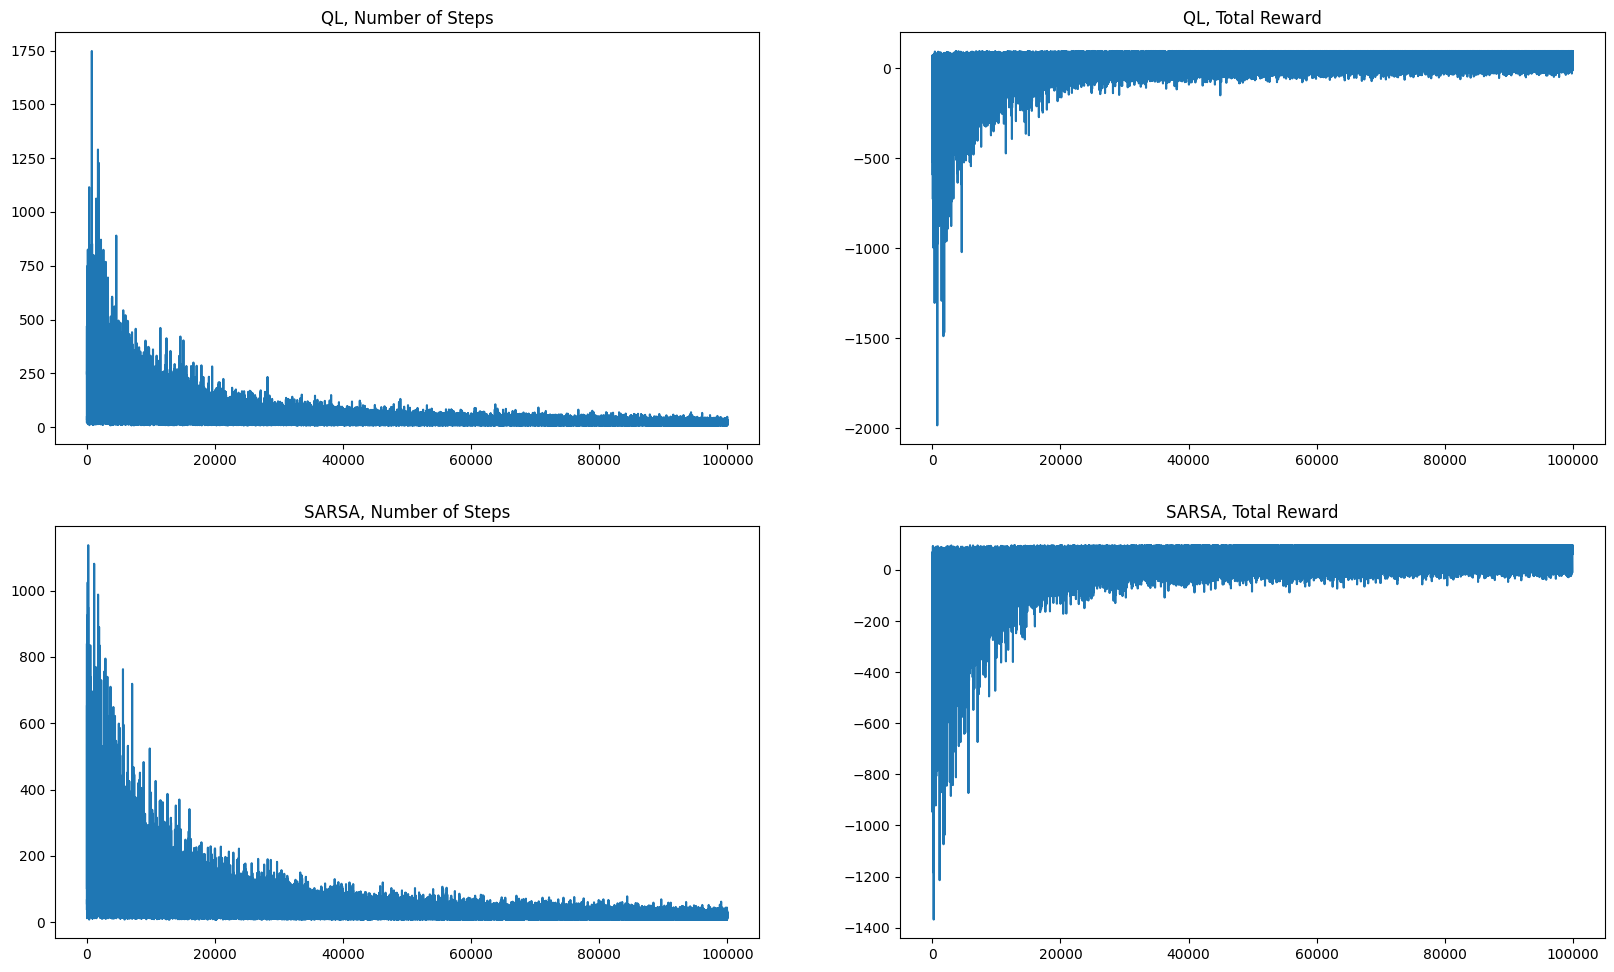

In [10]:
# successful_steps, game_rewards
plt.rcParams["figure.figsize"] = (20,12)
plt.rcParams["figure.dpi"] = 100

plt.subplot(2, 2, 1);
plt.title("QL, Number of Steps")
plt.plot(ql_number_of_steps);
plt.subplot(2, 2, 2);
plt.title("QL, Total Reward")
plt.plot(ql_game_rewards);
plt.subplot(2, 2, 3);
plt.title("SARSA, Number of Steps")
plt.plot(sarsa_number_of_steps);
plt.subplot(2, 2, 4);
plt.title("SARSA, Total Reward")
plt.plot(sarsa_game_rewards);

In [11]:
ql_play_number_of_steps, ql_play_game_rewards = random_agent.play(method="QL", epsilon =0, num_games = 20001);
sarsa_play_number_of_steps, sarsa_play_game_rewards = random_agent.play(method="SARSA", epsilon =0, num_games = 20001);

print(f"Q-Learning Method: Number of Steps:{ql_play_number_of_steps.mean():0.02f}±{ql_play_number_of_steps.std():0.02f}, Game Rewards:{ql_play_game_rewards.mean():0.02f}±{ql_play_game_rewards.std():0.02f}")
print(f"Sarsa      Method: Number of Steps:{sarsa_play_number_of_steps.mean():0.02f}±{sarsa_play_number_of_steps.std():0.02f}, Game Rewards:{sarsa_play_game_rewards.mean():0.02f}±{sarsa_play_game_rewards.std():0.02f}")

starting game 0
starting game 20000
starting game 0
starting game 20000
Q-Learning Method: Number of Steps:11.90±2.45, Game Rewards:94.41±1.60
Sarsa      Method: Number of Steps:12.17±2.54, Game Rewards:94.32±1.49


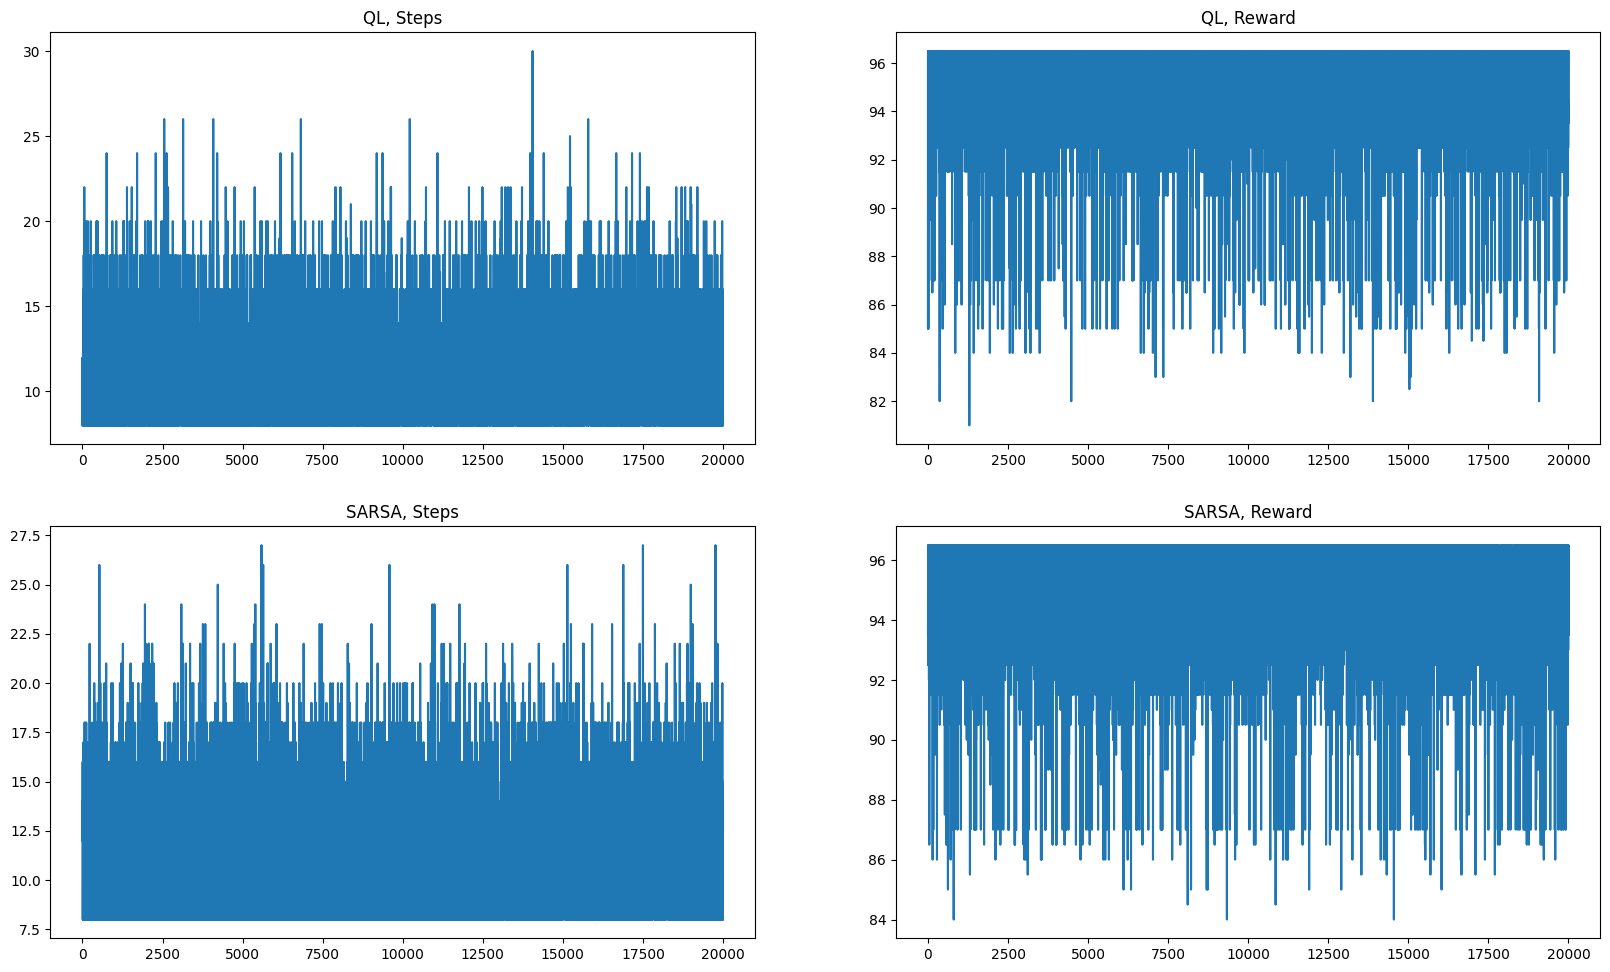

In [13]:
# successful_steps, game_rewards
plt.rcParams["figure.figsize"] = (20,12)
plt.rcParams["figure.dpi"] = 100

plt.subplot(2, 2, 1);
plt.title("QL, Steps")
plt.plot(ql_play_number_of_steps);
plt.subplot(2, 2, 2);
plt.title("QL, Reward")
plt.plot(ql_play_game_rewards);
plt.subplot(2, 2, 3);
plt.title("SARSA, Steps")
plt.plot(sarsa_play_number_of_steps)
plt.subplot(2, 2, 4);
plt.title("SARSA, Reward")
plt.plot(sarsa_play_game_rewards);

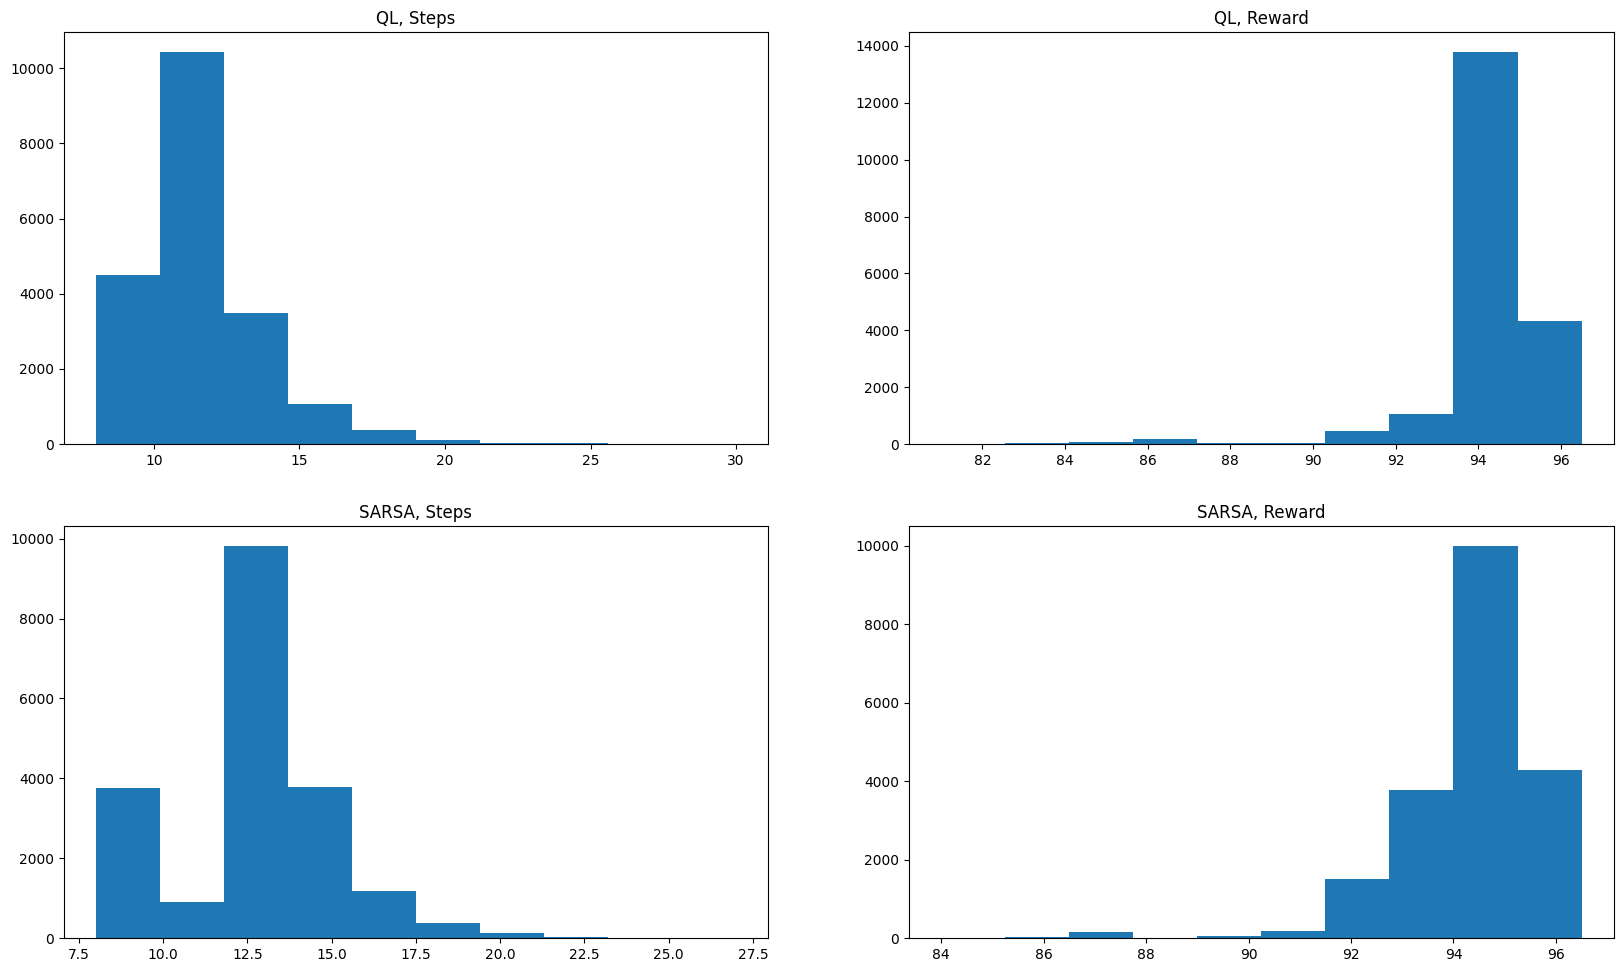

In [14]:
# successful_steps, game_rewards
plt.rcParams["figure.figsize"] = (20,12)
plt.rcParams["figure.dpi"] = 100

plt.subplot(2, 2, 1);
plt.title("QL, Steps")
plt.hist(ql_play_number_of_steps, bins=10);
plt.subplot(2, 2, 2);
plt.title("QL, Reward")
plt.hist(ql_play_game_rewards);
plt.subplot(2, 2, 3);
plt.title("SARSA, Steps")
plt.hist(sarsa_play_number_of_steps);
plt.subplot(2, 2, 4);
plt.title("SARSA, Reward")
plt.hist(sarsa_play_game_rewards);

In [15]:
'''
alpha: learning rate 
gamma: disccounted rate
epsilon: exploration ratio
temporary_game_check: print out results every "temporary_game_check" games
num_games: number of trials
'''
method = "QL"
successful_steps = []
game_rewards = [] 
epsilon = 0

# foreach game, reset the environment            
# cart x position, cart velocity, pole theta, pole velocity
s = random_agent.env.reset()
# e-greedy policy: epsilon chance of exploring and (1-epsilon) chance of exploiting 
rand = np.random.random()
a = random_agent.get_max_reward_action(s, method) if rand < (1 - epsilon) else random_agent.env.action_space.sample()
done = False

number_of_steps = 0
game_reward = 0

# keep playing
while not done:
    '''
    Move to the next state, use the next state value to update back the current state
    '''
    env._render()
    
    # Move to next state
    state, reward, done, info = random_agent.env.step(a)
    number_of_steps += 1
    print(f"Step {number_of_steps}, Reward: {game_reward} + {reward}]")
    # update (depends on learning method)
    if method == "QL":
        rand = np.random.random()
        a_ = random_agent.get_max_reward_action(state, method) if rand < (1-epsilon) else random_agent.env.action_space.sample()
    elif method == "SARSA":
        rand = np.random.random()
        a_ = random_agent.get_max_reward_action(state, method) if rand < (1-epsilon) else random_agent.env.action_space.sample()
    # update next state
    s, a = state, a_        

    game_reward += reward

print(f"Game reward: {game_reward} in {number_of_steps} Steps.")



       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    웃   .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
Step 1, Reward: 0 + -0.5]
       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    .    웃   .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    